# Q3 - Representation Learning

We want a low-dimensional representations that are transferable to similar
datasets

For the input data we decided to use time grid from Q1.3.

## Q3.1 - Pretraining and Linear Probes

### Q3.1.1


In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from project_1.loading import *
from project_1.dataset import *
from torch.utils.data import DataLoader, TensorDataset

torch.manual_seed(42)

2025-04-06 11:06:11.922 | INFO     | project_1.config:<module>:11 - PROJ_ROOT path is: C:\Users\Menelao\Desktop\Health_care\project-1-ml4hc



#### Model Basis
To ensure fair comparison (as requested), the architecture builds upon **LSTM** from Q2 - the top-performing RNN variant in previous experiments:

- **Base Architecture**: 2-layer LSTM
- **Hidden Units**: 64
- **Dropout**: 0.3

#### Monitoring Approach:
**Reconstruction Loss (MSE)** tracked across epochs




## Define the Encoder and Decoder => Auto Encoder

In [2]:
# Define the encoder model using an LSTM with dropout.
class TimeSeriesEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, embedding_dim, dropout=0.3):
        super(TimeSeriesEncoder, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                            batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        # Project the last hidden state to a lower-dimensional embedding space.
        self.fc = nn.Linear(hidden_size, embedding_dim)
    
    def forward(self, x):
        # x: [batch, seq_len, input_size]
        _, (h_n, _) = self.lstm(x)
        h_last = h_n[-1]  # Shape: [batch, hidden_size]
        h_last = self.dropout(h_last)
        embedding = self.fc(h_last)  # Shape: [batch, embedding_dim]
        return embedding
    
# Define the decoder model that reconstructs the time series from the embedding.
class TimeSeriesDecoder(nn.Module):
    def __init__(self, embedding_dim, hidden_size, num_layers, output_size, seq_len, dropout=0.3):
        super(TimeSeriesDecoder, self).__init__()
        self.seq_len = seq_len
        self.fc = nn.Linear(embedding_dim, hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, 
                            batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.out = nn.Linear(hidden_size, output_size)
    
    def forward(self, embedding):
        # embedding: [batch, embedding_dim]
        # Map the embedding to the hidden state dimension.
        hidden = self.fc(embedding)  # Shape: [batch, hidden_size]
        hidden = self.dropout(hidden)
        # Repeat the hidden state seq_len times to create a sequence input.
        repeated = hidden.unsqueeze(1).repeat(1, self.seq_len, 1)  # Shape: [batch, seq_len, hidden_size]
        lstm_out, _ = self.lstm(repeated)
        lstm_out = self.dropout(lstm_out)
        # Reconstruct the input features at each time step.
        output = self.out(lstm_out)  # Shape: [batch, seq_len, output_size]
        return output

# Combine encoder and decoder into an autoencoder.
class TimeSeriesAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, embedding_dim, seq_len, dropout=0.3):
        super(TimeSeriesAutoencoder, self).__init__()
        self.encoder = TimeSeriesEncoder(input_size, hidden_size, num_layers, embedding_dim, dropout)
        self.decoder = TimeSeriesDecoder(embedding_dim, hidden_size, num_layers, input_size, seq_len, dropout)
    
    def forward(self, x):
        embedding = self.encoder(x)
        reconstruction = self.decoder(embedding)
        return reconstruction


In [3]:
def pretrain_autoencoder(autoencoder, train_loader, val_loader, num_epochs=20, learning_rate=1e-3, device='cpu'):
    autoencoder.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        # Training Phase
        autoencoder.train()
        total_train_loss = 0.0
        for batch in train_loader:
            inputs = batch[0].to(device)
            optimizer.zero_grad()
            reconstruction = autoencoder(inputs)
            loss = criterion(reconstruction, inputs)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * inputs.size(0)
        avg_train_loss = total_train_loss / len(train_loader.dataset)
        
        # Validation Phase
        autoencoder.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                inputs = batch[0].to(device)
                reconstruction = autoencoder(inputs)
                loss = criterion(reconstruction, inputs)
                total_val_loss += loss.item() * inputs.size(0)
        avg_val_loss = total_val_loss / len(val_loader.dataset)
        
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")
        
    return autoencoder

## Load the data and prepare the DataLoaders

In [4]:
set_a, set_b, set_c = load_final_data_without_ICU()
death_a, death_b, death_c = load_outcomes()

Shapes of the datasets:
Set A: (183416, 42) Set B: (183495, 42) Set C: (183711, 42)
Shapes of labels:
Set A: (4000, 2) Set B: (4000, 2) Set C: (4000, 2)


In [5]:
train_dataset = create_dataset_from_timeseries(set_a, death_a["In-hospital_death"])
validation_dataset = create_dataset_from_timeseries(set_b, death_b["In-hospital_death"])
test_dataset = create_dataset_from_timeseries(set_c, death_c["In-hospital_death"])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

train_dataset.tensors[0].shape

torch.Size([4000, 49, 40])

# Training

In [6]:
# Define the hyperparameters
hidden_size = 64
input_size = train_dataset.tensors[0].shape[2] # The features
num_layers = 2
embedding_dim = 128
seq_len = train_dataset.tensors[0].shape[1] # The sequence length

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

autoencoder = TimeSeriesAutoencoder(input_size, hidden_size, num_layers, embedding_dim, seq_len)
pretrained_autoencoder = pretrain_autoencoder(autoencoder, train_loader, validation_loader, num_epochs=20, device=device)

# Extract the pretrained encoder for downstream tasks (e.g., linear probing).
pretrained_encoder = pretrained_autoencoder.encoder
print("Pretraining complete. The encoder is ready for use in a linear probe.")

Epoch 1/20 - Train Loss: 30.5335 - Val Loss: 10.8393
Epoch 2/20 - Train Loss: 29.8941 - Val Loss: 11.1624
Epoch 3/20 - Train Loss: 29.8417 - Val Loss: 11.1624
Epoch 4/20 - Train Loss: 29.8002 - Val Loss: 11.1454
Epoch 5/20 - Train Loss: 29.7511 - Val Loss: 11.1401
Epoch 6/20 - Train Loss: 29.6932 - Val Loss: 11.1656
Epoch 7/20 - Train Loss: 29.6386 - Val Loss: 11.2007
Epoch 8/20 - Train Loss: 29.5636 - Val Loss: 11.2136
Epoch 9/20 - Train Loss: 29.4476 - Val Loss: 11.3439
Epoch 10/20 - Train Loss: 29.1510 - Val Loss: 11.2440
Epoch 11/20 - Train Loss: 28.6394 - Val Loss: 11.8212
Epoch 12/20 - Train Loss: 28.2518 - Val Loss: 12.1905
Epoch 13/20 - Train Loss: 27.8388 - Val Loss: 10.1719
Epoch 14/20 - Train Loss: 27.0446 - Val Loss: 10.2849
Epoch 15/20 - Train Loss: 26.6154 - Val Loss: 10.1966
Epoch 16/20 - Train Loss: 26.2288 - Val Loss: 10.1884
Epoch 17/20 - Train Loss: 25.9564 - Val Loss: 10.1290
Epoch 18/20 - Train Loss: 25.6785 - Val Loss: 10.2547
Epoch 19/20 - Train Loss: 25.4380 - V

# Q3.1.2 - Freeze and compute embeddings

In [8]:
# Freeze the encoder weights
pretrained_encoder.eval()
for param in pretrained_encoder.parameters():
    param.requires_grad = False

def extract_embeddings(encoder, dataloader, device):
    """
    Compute embeddings for all samples in the dataloader using the provided encoder.
    
    Returns:
        embeddings: numpy array of shape [num_samples, embedding_dim]
        targets: numpy array of shape [num_samples]
    """
    encoder.eval()
    embeddings_list = []
    targets_list = []
    with torch.no_grad():
        for batch in dataloader:
            # Assuming each batch is a tuple (data, target)
            inputs, targets = batch[0].to(device), batch[1]
            embeddings = encoder(inputs)  # compute embeddings
            embeddings_list.append(embeddings.cpu().numpy())
            targets_list.append(targets.numpy())
    embeddings_all = np.concatenate(embeddings_list, axis=0)
    targets_all = np.concatenate(targets_list, axis=0)
    return embeddings_all, targets_all

Now, extract the embedding and fit a logistic regression on the embeddings

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score

# Extract embeddings for train, validation, and test sets.
train_embeddings, train_targets = extract_embeddings(pretrained_encoder, train_loader, device)
val_embeddings, val_targets = extract_embeddings(pretrained_encoder, validation_loader, device)
test_embeddings, test_targets = extract_embeddings(pretrained_encoder, test_loader, device)

# Train a logistic regression classifier on the training embeddings.
clf = LogisticRegression(max_iter=1000)
clf.fit(train_embeddings, train_targets)

# Evaluate on validation and test sets.
val_probs = clf.predict_proba(val_embeddings)[:, 1]
test_probs = clf.predict_proba(test_embeddings)[:, 1]

val_preds = clf.predict(val_embeddings)
test_preds = clf.predict(test_embeddings)

val_acc = accuracy_score(val_targets, val_preds)
test_acc = accuracy_score(test_targets, test_preds)

val_roc_auc = roc_auc_score(val_targets, val_probs)
test_roc_auc = roc_auc_score(test_targets, test_probs)

val_auprc = average_precision_score(val_targets, val_probs)
test_auprc = average_precision_score(test_targets, test_probs)

#print("Validation Accuracy: {:.4f}".format(val_acc))
print("Validation ROC AUC: {:.4f}".format(val_roc_auc))
print("Validation AUPRC: {:.4f}".format(val_auprc))
#print("Test Accuracy: {:.4f}".format(test_acc))
print("Test ROC AUC: {:.4f}".format(test_roc_auc))
print("Test AUPRC: {:.4f}".format(test_auprc))

Validation ROC AUC: 0.5865
Validation AUPRC: 0.2344
Test ROC AUC: 0.5695
Test AUPRC: 0.2137


***

## Q3.2 Simulate label scarcity

Now, train the logistic for 100, 500, 1000 patients and evaluate it's results. 
For the preparation of the data for the logistic, we use the same as the logistic regression from Q1. That's why we just use one chunk.

In [14]:
set_a, set_b, set_c = load_final_data_without_ICU()
death_a, death_b, death_c = load_outcomes()

train_set = set_a.merge(death_a, on="RecordID")
val_set = set_b.merge(death_b, on="RecordID") 
test_set = set_c.merge(death_c, on="RecordID")

# Define aggregation rules
aggregation_rules = {
    "Age": "last",
    "Gender": "last",
    "Height": "last",
    "Albumin": "last",
    "ALP": "last",
    "ALT": "last",
    "AST": "last",
    "Bilirubin": "last",
    "BUN": "last",
    "Cholesterol": "last",
    "Creatinine": "last",
    "DiasABP": "mean",
    "FiO2": "mean",
    "GCS": "min",
    "Glucose": "mean",
    "HCO3": "last",
    "HCT": "last",
    "HR": "mean",
    "K": "last",
    "Lactate": "max",
    "Mg": "last",
    "MAP": "mean",
    "MechVent": "last",
    "Na": "last",
    "NIDiasABP": "mean",
    "NIMAP": "mean",
    "NISysABP": "mean",
    "PaCO2": "last",
    "PaO2": "mean",
    "pH": "last",
    "Platelets": "last",
    "RespRate": "mean",
    "SaO2": "mean",
    "SysABP": "mean",
    "Temp": "max",
    "TroponinI": "max",
    "TroponinT": "max",
    "Urine": "sum",
    "WBC": "last",
    "Weight": "last",
    "In-hospital_death": "max"  # If any 1 exists for a patient, return 1 (not necessary)
}

# Perform aggregation
train_aggregated = train_set.groupby("RecordID").agg(aggregation_rules).reset_index()
val_aggregated = val_set.groupby("RecordID").agg(aggregation_rules).reset_index()
test_aggregated = test_set.groupby("RecordID").agg(aggregation_rules).reset_index()


# Separate Predictors (X) and Target (y)
X_train = train_aggregated.drop(columns=["RecordID", "In-hospital_death"])
y_train = train_aggregated["In-hospital_death"]

X_val = val_aggregated.drop(columns=["RecordID", "In-hospital_death"])
y_val = val_aggregated["In-hospital_death"]

X_test = test_aggregated.drop(columns=["RecordID", "In-hospital_death"])
y_test = test_aggregated["In-hospital_death"]

# Visualize the shape of the datasets
print(X_train.shape, y_train.shape)


Shapes of the datasets:
Set A: (183416, 42) Set B: (183495, 42) Set C: (183711, 42)
Shapes of labels:
Set A: (4000, 2) Set B: (4000, 2) Set C: (4000, 2)
(4000, 40) (4000,)


# Q3.2.1 - Supervised Model

In [40]:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score
import numpy as np

# Define the sample sizes
sample_sizes = [100, 500, 1000]

# Store results
results = []

for sample_size in sample_sizes:
    print(f"Training with {sample_size} patients...")
    
    # Sample a subset of the training data
    sample_indices = np.random.choice(len(X_train), sample_size, replace=False)
    X_train_subset = X_train.iloc[sample_indices]
    y_train_subset = y_train.iloc[sample_indices]

    
    # Train the Logistic Regression model
    clf = LogisticRegression(random_state=42, max_iter=1000)
    clf.fit(X_train_subset, y_train_subset)
    
    # Evaluate on the validation set
    y_valid_proba = clf.predict_proba(X_val)[:, 1]
    roc_auc_valid = roc_auc_score(y_val, y_valid_proba)
    auprc_valid = average_precision_score(y_val, y_valid_proba)
    print(f"Validation ROC AUC: {roc_auc_valid:.3f}, AUPRC: {auprc_valid:.3f}")
    
    # Evaluate on the test set
    y_test_proba = clf.predict_proba(X_test)[:, 1]
    roc_auc_test = roc_auc_score(y_test, y_test_proba)
    auprc_test = average_precision_score(y_test, y_test_proba)
    print(f"Test ROC AUC: {roc_auc_test:.3f}, AUPRC: {auprc_test:.3f}")
    
    # Store results
    results.append({
        'sample_size': sample_size,
        'roc_auc_valid': roc_auc_valid,
        'auprc_valid': auprc_valid,
        'roc_auc_test': roc_auc_test,
        'auprc_test': auprc_test
    })


Training with 100 patients...
Validation ROC AUC: 0.598, AUPRC: 0.256
Test ROC AUC: 0.638, AUPRC: 0.267
Training with 500 patients...
Validation ROC AUC: 0.744, AUPRC: 0.350
Test ROC AUC: 0.726, AUPRC: 0.341
Training with 1000 patients...
Validation ROC AUC: 0.762, AUPRC: 0.361
Test ROC AUC: 0.757, AUPRC: 0.354


# Q3.2.2 - Linear Probs

Training of the linear probs with reduced samples

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score
import numpy as np

# Extract embeddings for train, validation, and test sets.
train_embeddings, train_targets = extract_embeddings(pretrained_encoder, train_loader, device)
val_embeddings, val_targets = extract_embeddings(pretrained_encoder, validation_loader, device)
test_embeddings, test_targets = extract_embeddings(pretrained_encoder, test_loader, device)

# Define the sample sizes
sample_sizes = [100, 500, 1000]

# Store results
results = []

for sample_size in sample_sizes:
    print("-------------------------------------------------")
    print(f"Training with {sample_size} patients...")
    
    # Sample a subset of the training data
    sample_indices = np.random.choice(len(train_embeddings), sample_size, replace=False)
    train_embeddings_subset = train_embeddings[sample_indices]
    train_targets_subset = train_targets[sample_indices]
    
    # Train a logistic regression classifier on the training embeddings.
    clf = LogisticRegression(max_iter=1000)
    clf.fit(train_embeddings_subset, train_targets_subset)
    
    # Evaluate on validation and test sets.
    val_probs = clf.predict_proba(val_embeddings)[:, 1]
    test_probs = clf.predict_proba(test_embeddings)[:, 1]
    
    val_preds = clf.predict(val_embeddings)
    test_preds = clf.predict(test_embeddings)
    
    val_roc_auc = roc_auc_score(val_targets, val_probs)
    test_roc_auc = roc_auc_score(test_targets, test_probs)
    
    val_auprc = average_precision_score(val_targets, val_probs)
    test_auprc = average_precision_score(test_targets, test_probs)
    
    print(f"Validation ROC AUC: {val_roc_auc:.4f}, AUPRC: {val_auprc:.4f}")
    print(f"Test ROC AUC: {test_roc_auc:.4f}, AUPRC: {test_auprc:.4f}")
    print("-------------------------------------------------\n")

    # Store results
    results.append({
        'sample_size': sample_size,
        'val_roc_auc': val_roc_auc,
        'val_auprc': val_auprc,
        'test_roc_auc': test_roc_auc,
        'test_auprc': test_auprc
    })


-------------------------------------------------
Training with 100 patients...
Validation ROC AUC: 0.4684, AUPRC: 0.1543
Test ROC AUC: 0.5624, AUPRC: 0.1777
-------------------------------------------------

-------------------------------------------------
Training with 500 patients...
Validation ROC AUC: 0.5667, AUPRC: 0.2063
Test ROC AUC: 0.6320, AUPRC: 0.2439
-------------------------------------------------

-------------------------------------------------
Training with 1000 patients...
Validation ROC AUC: 0.5750, AUPRC: 0.2217
Test ROC AUC: 0.6346, AUPRC: 0.2575
-------------------------------------------------



Do you observe an advantage of your pretrained network under label scarcity? How long is it
useful to invest in pretraining versus directly training the supervised model?


None...

***

# Q3.3 - Visualization of Embeddings

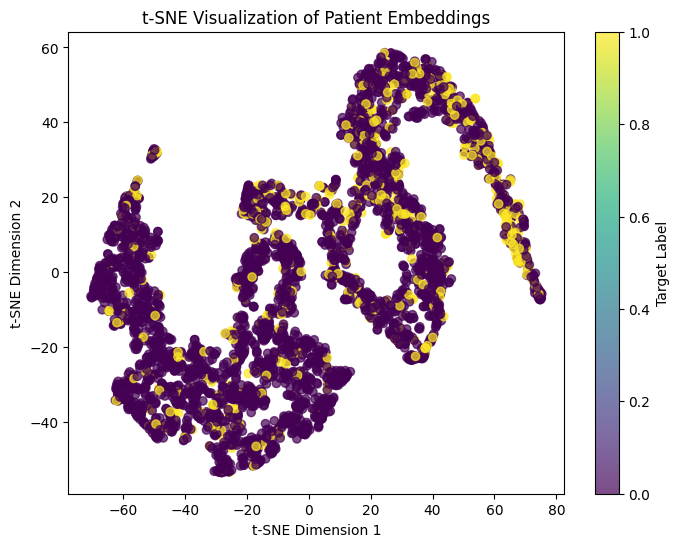

Silhouette Score: 0.041572716


In [37]:
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

embeddings, labels = extract_embeddings(pretrained_encoder, test_loader, device)

# Perform t-SNE dimensionality reduction to 2D.
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Visualize the 2D embeddings.
plt.figure(figsize=(8, 6))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Target Label')
plt.title("t-SNE Visualization of Patient Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

# Compute a quantitative clustering metric (Silhouette Score) using the target labels.
score = silhouette_score(embeddings_2d, labels)
print("Silhouette Score:", score)


Bad performance... let's try a grid search based on Siluohette

Best Hyperparameters: {'perplexity': 50, 'learning_rate': 200, 'max_iter': 250}
Best Silhouette Score: 0.06807464


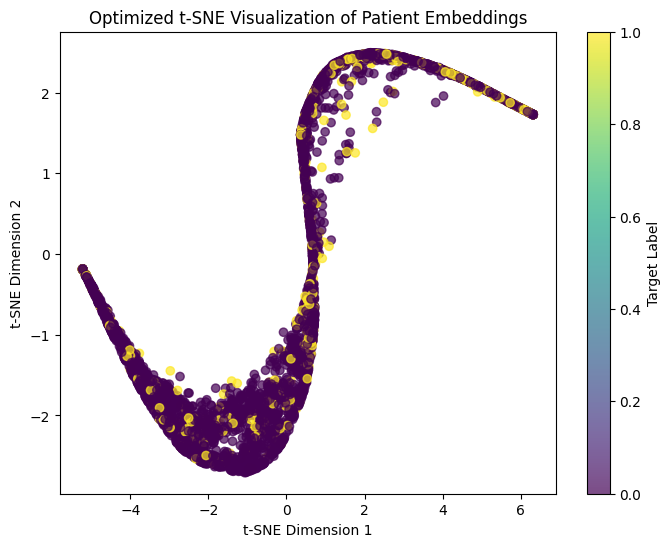

In [39]:
from itertools import product
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

# Define hyperparameter grid
perplexities = [5, 30, 50]
learning_rates = [10, 200, 1000]
n_iters = [250, 500, 1000]

best_score = -1
best_params = {}
best_embeddings = None

# Grid search over hyperparameters
for perplexity, learning_rate, max_iter in product(perplexities, learning_rates, n_iters):
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, max_iter=max_iter, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)
    
    # Compute Silhouette Score
    try:
        score = silhouette_score(embeddings_2d, labels)
    except ValueError:
        continue  # Skip invalid configurations
    
    if score > best_score:
        best_score = score
        best_params = {'perplexity': perplexity, 'learning_rate': learning_rate, 'max_iter': max_iter}
        best_embeddings = embeddings_2d

# Print best hyperparameters
print("Best Hyperparameters:", best_params)
print("Best Silhouette Score:", best_score)

# Visualize best embedding
plt.figure(figsize=(8, 6))
scatter = plt.scatter(best_embeddings[:, 0], best_embeddings[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Target Label')
plt.title("Optimized t-SNE Visualization of Patient Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()


## UMAP8 (requires the package umap-learn)

In [ ]:
import umap
# Initialize UMAP with some typical hyperparameters.
# You may tune n_neighbors, min_dist, etc. for best results.
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)

# Fit and transform the embeddings into 2D.
embeddings_2d = reducer.fit_transform(embeddings)

# Plot the 2D embeddings, colored by label.
plt.figure(figsize=(8, 6))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                      c=labels, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Target Label')
plt.title("UMAP Visualization of Patient Embeddings")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()

# (Optional) Compute a clustering metric, e.g., silhouette score.
score = silhouette_score(embeddings_2d, labels)
print("Silhouette Score:", score)
